In [1]:
import sys
import os

def get_FGCE_Directory():
    """Get the path of the 'FGCE' directory."""
    current_dir = os.getcwd()
    while os.path.basename(current_dir) != 'FGCE':      
        current_dir = os.path.dirname(current_dir)
        if current_dir == os.path.dirname(current_dir):
            return None
    return current_dir

def get_path_separator():
    """Get the system-specific directory separator."""
    return os.sep

FGCE_DIR = get_FGCE_Directory()
sys.path.append(FGCE_DIR)
sep = get_path_separator()

from main import *

2024-08-12 15:11:38.150022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 15:11:38.160856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 15:11:38.164156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 15:11:38.172944: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 15:11:38.736139: W tensorflow/compiler/tf2

# Decide Epsilon parameter

In [15]:
from main import *
from utils import *
import math

dataset_results = {}

tp = 0.6
skip_bandwith_calculation=True
datasetName = 'Student'

data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns, min_max_scaler, data_df_copy, continuous_featues, one_hot_encode_features = load_dataset(datasetName=datasetName)
TEST_SIZE = 0.3

X = data[FEATURE_COLUMNS]
y = data[TARGET_COLUMNS]

data_np = data.to_numpy()
attr_col_mapping = {col: i for i, col in enumerate(data.columns)}

X = data_np[:, [attr_col_mapping[col] for col in FEATURE_COLUMNS]]
if isinstance(TARGET_COLUMNS, str):
    y = data_np[:, attr_col_mapping[TARGET_COLUMNS]]
else:
    y = data_np[:, [attr_col_mapping[col] for col in TARGET_COLUMNS]]

X_train, X_test, y_train, y_test = train_test_split(
    data[FEATURE_COLUMNS],
    data[TARGET_COLUMNS],
    test_size=TEST_SIZE,
    random_state=utils.random_seed,
    shuffle=True
)

index_mapping_test = {new_index: original_index for new_index, original_index in enumerate(X_test.index)}
index_mapping_train = {new_index: original_index for new_index, original_index in enumerate(X_train.index)}

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy().reshape(-1, 1)
y_test_np = y_test.to_numpy().reshape(-1, 1)

data_train = np.concatenate((X_train_np, y_train_np), axis=1)
data_test = np.concatenate((X_test_np, y_test_np), axis=1)

index_mapping = {new_index: original_index for new_index, original_index in enumerate(X_test.index)}

if "LR_classifier_face_data.pk" in os.listdir(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}"):
        print("Loading classifier from file ...")
        clf = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}LR_classifier_face_data.pk", "rb"))
else:
    clf = LogisticRegression(random_state=utils.random_seed)
    clf.fit(X_train, y_train)

    print("Training accuracy:", clf.score(X_train, y_train))
    print("Testing accuracy:", clf.score(X_test, y_test))

    if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}"):
        os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}")

    pk.dump(clf, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}LR_classifier_face_data.pk", 'wb'))

FN, negative_points, positive_points, FP = utils.get_FN_Negatives_Positives(data_test, clf, tp, attr_col_mapping, FEATURE_COLUMNS, TARGET_COLUMNS, index_mapping)

results = {}
start=0.1
step=0.58

e = 0.1
if os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl"):
    distances = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl", "rb"))
else:
    kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
    kernel.fitKernel(X)
    fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
    feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=datasetName)
    dng_obj = GraphBuilder(feasibility_constraints, FEATURE_COLUMNS, X, kernel, exclude_columns=True)
    distances, graph, densities = dng_obj.compute_pairwise_distances_and_graph_within_subgroups(datasetName, data[FEATURE_COLUMNS], e, feasibility_constraints, None)

max_distances_in_the_dataset = math.ceil(np.max(distances))
print(f"Max distance in the dataset: {max_distances_in_the_dataset}")

for e in np.arange(start, max_distances_in_the_dataset, step):
    e = round(e, 1)
    print(f"Processing epsilon: {e}")
    if os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl") and os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl"):
        graph = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl", "rb"))
        kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
        kernel.fitKernel(X)
        fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
        fgce.set_graph(graph)

        print("Loading distances from file ...")
        distances = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl", "rb"))

    else:
        kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
        kernel.fitKernel(X)
        fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
        feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=datasetName)

        start_time = time.time()
        dng_obj = GraphBuilder(feasibility_constraints, FEATURE_COLUMNS, X, kernel, exclude_columns=True)
        distances, graph, densities = dng_obj.compute_pairwise_distances_and_graph_within_subgroups(datasetName, data[FEATURE_COLUMNS], e, feasibility_constraints, None)
        end_time = time.time()
        execution_time = end_time - start_time
        print("Distances and graph initialization: ", execution_time, " seconds")

        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}"):
            os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}")
        
        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities{sep}"):
            os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities")

        #  if this file "f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl"" does not exist, then save the distances to the file
        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl"):
            pk.dump(distances, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl", "wb"))

        pk.dump(graph, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl", "wb"))
        pk.dump(densities, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities{sep}Densities_{e}.pkl", "wb"))

    try:
        print(f"Max possible distance considered in graph: {np.max([edge[2]['distance'] for edge in graph.edges(data=True)])}")
    except:
        print(f"Max possible distance considered in graph: {0}")

    strongly_connected_components = list(nx.strongly_connected_components(graph))
    weakly_connected_components = list(nx.weakly_connected_components(graph))

    connected_nodes = sum(1 for node, degree in graph.degree() if degree > 0)

    graph_density = nx.density(graph)

    d = {"strongly_connected_components": len(strongly_connected_components), "weakly_connected_components": len(weakly_connected_components),
        "Percentage_of_connected_nodes": (connected_nodes/len(X))*100, "Density": graph_density * 100}
    print(d,"\n")
    results[e] = d

Loading classifier from file ...
Max distance in the dataset: 5
Processing epsilon: 0.1
Calculating bandwidth for Student...
Bandwidth: 0.09317241379310345
Fitting kernel...
Loading distances from file ...
Max possible distance considered in graph: 0.09375
{'strongly_connected_components': 648, 'weakly_connected_components': 648, 'Percentage_of_connected_nodes': 0.30816640986132515, 'Density': 0.0004755654473168597} 

Processing epsilon: 0.7
Calculating bandwidth for Student...
Bandwidth: 0.09317241379310345
Fitting kernel...
Loading distances from file ...
Max possible distance considered in graph: 0.25
{'strongly_connected_components': 647, 'weakly_connected_components': 646, 'Percentage_of_connected_nodes': 0.9244992295839755, 'Density': 0.0011889136182921495} 

Processing epsilon: 1.3
Calculating bandwidth for Student...
Bandwidth: 0.09317241379310345
Fitting kernel...
Loading distances from file ...
Max possible distance considered in graph: 1.2692955176439846
{'strongly_connected

/tmp/ipykernel_657554/759583545.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig_legend.tight_layout(pad=1.0)


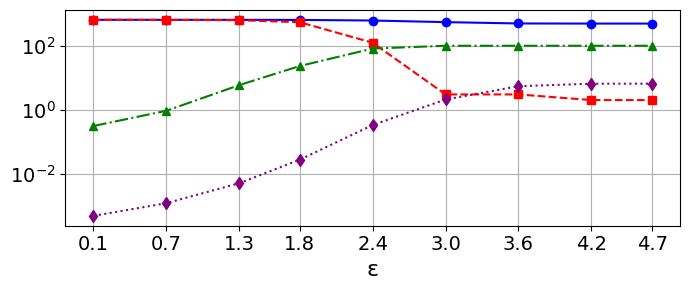

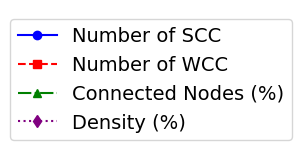

In [ ]:
import matplotlib.pyplot as plt

epsilons = list(results.keys())
strongly_connected_components = [results[k]["strongly_connected_components"] for k in epsilons]
weakly_connected_components = [results[k]["weakly_connected_components"] for k in epsilons]
node_connectivity = [results[k]["Percentage_of_connected_nodes"] for k in epsilons]
edge_connectivity = [results[k]["Density"] for k in epsilons]

fig, ax = plt.subplots(figsize=(7,3))
plt.gcf().set_size_inches(7,3)
line1, = ax.plot(epsilons, strongly_connected_components, marker='o', linestyle='-', color='b', label="Number of SCC")
line2, = ax.plot(epsilons, weakly_connected_components, marker='s', linestyle='--', color='r', label="Number of WCC")
line3, = ax.plot(epsilons, node_connectivity, marker='^', linestyle='-.', color='g', label="Connected Nodes (%)")
line4, = ax.plot(epsilons, edge_connectivity, marker='d', linestyle=':', color='purple', label="Density (%)")
ax.set_xlabel("ε", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_yscale('log')
ax.set_xticks(epsilons)
plt.grid(True)
plt.tight_layout()

fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}figs{sep}{datasetName}_connectivity_plot_no_legend.pdf")


fig_legend = plt.figure(figsize=(1, 1))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend([line1, line2, line3, line4], [line.get_label() for line in [line1, line2, line3, line4]], loc='upper center', fontsize=14)
ax_legend.axis('off')
fig_legend.tight_layout(pad=1.0)
fig_legend.savefig(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}figs{sep}{datasetName}_legend.pdf", bbox_inches='tight')
plt.show()

In [4]:
def filter_subdict(experiment, allowed_subkeys):
    result = {}
    for key, value in experiment.items():
        if isinstance(value, dict):
            filtered_subdict = {}
            for subkey, subvalue in value.items():
                if subkey in allowed_subkeys:
                    filtered_subdict[subkey] = subvalue
            result[key] = filtered_subdict
        else:
            result[key] = value
    return result


allowed_subkeys = ["Coverage", "Avg. distance", "Avg. path cost"]

In [5]:
lower_limit_range_for_d = 3.99 * (70/100) # 70% of the minimum maximum distance required for full coverage of the dataset from table 2 in the paper
lower_limit_range_for_d

2.793

In [6]:
data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns, min_max_scaler, data_df_copy, continuous_featues, one_hot_encode_features = load_dataset(datasetName="Student")
import numpy as np

def count_features(features, one_hot_features):
    feature_set = set()
    for feature in features:
        if feature == 'target':
            continue
        if feature in one_hot_features:
            # Extract the prefix to count only once
            prefix = feature.split('_')[0]
            feature_set.add(prefix)
        else:
            feature_set.add(feature)
    
    return len(feature_set)
feature_count = count_features(FEATURE_COLUMNS, one_hot_encode_features)
print(f"Number of unique features (counting one-hot encoded features only once): {feature_count}")

max_possible_distance_for_these_features = np.sqrt(feature_count)
print(f"Max possible distance for these features: {max_possible_distance_for_these_features}")

Number of unique features (counting one-hot encoded features only once): 30
Max possible distance for these features: 5.477225575051661


In [7]:
import math
print(f"Max distance in dataset: {max_possible_distance_for_these_features}") # from cell 2
step = np.round(((max_possible_distance_for_these_features - 0.1) /10), 1)
print(f"Step: {step}")

Max distance in dataset: 5.477225575051661
Step: 0.5


# AUC metrics

### (k) AUC related metrics

In [ ]:
from metrics import *
saturation_points, cov_for_saturation_points, auc_matrix = kAUC("Student", 3, 'sex', None, 11, lower_limit_range_for_d, max_possible_distance_for_these_features, step)

In [9]:
saturation_points

{1: {0.0: 4.293, 1.0: 4.293},
 2: {0.0: 3.793, 1.0: 4.293},
 3: {0.0: 3.793, 1.0: 4.293},
 4: {0.0: 3.293, 1.0: 4.293},
 5: {0.0: 3.293, 1.0: 4.293},
 6: {0.0: 3.293, 1.0: 4.293},
 7: {0.0: 3.293, 1.0: 4.293},
 8: {0.0: 3.293, 1.0: 4.293},
 9: {0.0: 3.293, 1.0: 4.293},
 10: {0.0: 3.293, 1.0: 4.293}}

In [10]:
cov_for_saturation_points

{1: {0.0: 81.81818181818183, 1.0: 100.0},
 2: {0.0: 100.0, 1.0: 100.0},
 3: {0.0: 100.0, 1.0: 100.0},
 4: {0.0: 100.0, 1.0: 100.0},
 5: {0.0: 100.0, 1.0: 100.0},
 6: {0.0: 100.0, 1.0: 100.0},
 7: {0.0: 100.0, 1.0: 100.0},
 8: {0.0: 100.0, 1.0: 100.0},
 9: {0.0: 100.0, 1.0: 100.0},
 10: {0.0: 100.0, 1.0: 100.0}}

In [11]:
auc_matrix

{1: {0.0: 0.66, 1.0: 0.9},
 2: {0.0: 0.87, 1.0: 0.92},
 3: {0.0: 0.92, 1.0: 0.93},
 4: {0.0: 0.95, 1.0: 0.94},
 5: {0.0: 0.95, 1.0: 0.94},
 6: {0.0: 0.95, 1.0: 0.94},
 7: {0.0: 0.95, 1.0: 0.94},
 8: {0.0: 0.95, 1.0: 0.94},
 9: {0.0: 0.95, 1.0: 0.94},
 10: {0.0: 0.95, 1.0: 0.94}}

### Running Other AUC-Related Metrics

To compute the `dAUC` and `cAUC` metrics for the Student dataset or any other dataset, follow a similar approach as demonstrated with the `kAUC` metric.

Simply adjust the `datasetName`, `epsilon`,  and other parameters as needed to apply these metrics to different datasets.

# Testing for different Classifiers

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=False, skip_graph_creation=False, skip_gcfe_calculation=False,
                            max_d = 5, cost_function = "max_vector_distance", k=2, k_selection_method="greedy_accross_all_ccs")[0]

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=True, skip_graph_creation=True, skip_gcfe_calculation=False,
                            classifier='xgb', max_d = 3, cost_function = "max_vector_distance",  k=2, k_selection_method="greedy_accross_all_ccs")[0]

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=True, skip_graph_creation=True, skip_gcfe_calculation=False,
                            classifier='dnn', max_d = 3, cost_function = "max_vector_distance", k=2, k_selection_method="greedy_accross_all_ccs")[0]

# Graph Structure and aWWCs for selected e

In [17]:
import networkx as nx
import pickle


with open(f"{FGCE_DIR}{sep}tmp{sep}Student{sep}Graphs{sep}Graph_3.pkl", "rb") as file:
    graph = pickle.load(file)

strongly_connected_components = list(nx.strongly_connected_components(graph))
weakly_connected_components = list(nx.weakly_connected_components(graph))

print("Strongly connected components:", len(strongly_connected_components))
print("Weakly connected components:", len(weakly_connected_components))

with open(f"{FGCE_DIR}{sep}tmp{sep}Student{sep}cost_constrained_GCFEs{sep}results_Student_eps3_tp0.6_k_2_cost_function_max_vector_distance_d_5_kmethod_greedy_accross_all_ccs.json", "r") as file:
    results = json.load(file)    

Strongly connected components: 548
Weakly connected components: 3


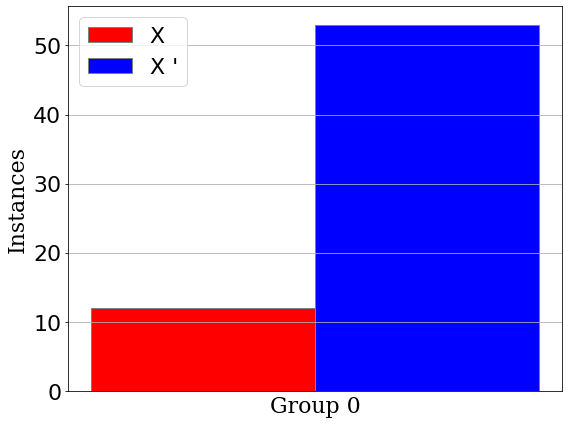

In [18]:
import matplotlib.pyplot as plt
bar_width = 50

fig, ax = plt.subplots(figsize=(12, 8))

stats = results['Graph Stats']['0.0']
aWCCs = set()
r0 = results['0.0']

for fn in r0:
    if fn in ['Coverage', 'Avg. distance', 'Avg. path cost', 'Median distance', 'Median path cost']:
        continue
    aWCCs.add(f"{r0[fn]['cfe_cc']}")

cc_names = [cc for cc in stats if cc.isdigit()]
num_cc = len(cc_names)

bar_width = 0.4
bar_gap = 0.5

center_poss = []
labels_added = {'positives': False, 'false_negatives': False}

for j, cc in enumerate(cc_names):
    if cc not in aWCCs:
        continue
    positives = stats[cc]['positives']
    false_negatives = stats[cc]['false_negatives']

    center_pos = j * (2 * bar_width + bar_gap)  
    r1 = center_pos - bar_width / 2  
    r2 = center_pos + bar_width / 2  

    if not labels_added['false_negatives']:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey', label='X')
        labels_added['false_negatives'] = True
    else:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey')

    if not labels_added['positives']:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey', label="X '")
        labels_added['positives'] = True
    else:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey')

    center_poss.append((r1 + r2) / 2)

ax.set_xticks([])

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax.set_xlabel(f'Group 0', fontsize=22, fontfamily='serif')
ax.set_ylabel('Instances', fontsize=22, fontfamily='serif')

ax.legend()
ax.grid(True)

ax.legend(fontsize=22)
fig_size = (8, 6)
plt.gcf().set_size_inches(fig_size)

plt.tight_layout()
plt.show()

fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}Compas{sep}figs{sep}ccs_positives_false_negatives_g0.pdf")


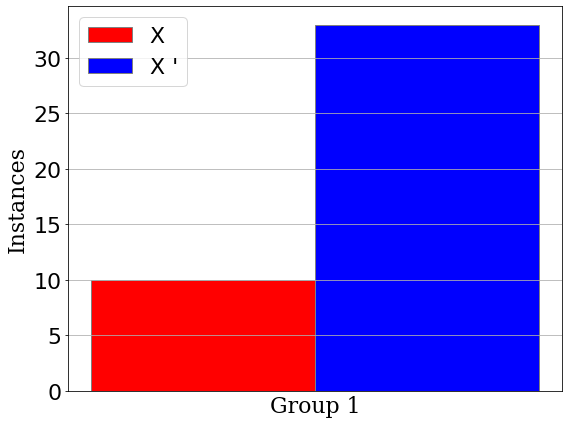

In [19]:
import matplotlib.pyplot as plt
bar_width = 50

fig, ax = plt.subplots(figsize=(12, 8))

stats = results['Graph Stats']['1.0']
aWCCs = set()
r0 = results['1.0']

for fn in r0:
    if fn in ['Coverage', 'Avg. distance', 'Avg. path cost', 'Median distance', 'Median path cost']:
        continue
    aWCCs.add(f"{r0[fn]['cfe_cc']}")

cc_names = [cc for cc in stats if cc.isdigit()]
num_cc = len(cc_names)

bar_width = 0.4
bar_gap = 0.5

center_poss = []
labels_added = {'positives': False, 'false_negatives': False}

for j, cc in enumerate(cc_names):
    if cc not in aWCCs:
        continue
    positives = stats[cc]['positives']
    false_negatives = stats[cc]['false_negatives']

    center_pos = j * (2 * bar_width + bar_gap)  
    r1 = center_pos - bar_width / 2  
    r2 = center_pos + bar_width / 2  

    if not labels_added['false_negatives']:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey', label='X')
        labels_added['false_negatives'] = True
    else:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey')

    if not labels_added['positives']:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey', label="X '")
        labels_added['positives'] = True
    else:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey')

    center_poss.append((r1 + r2) / 2)

ax.set_xticks([])

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax.set_xlabel(f'Group 1', fontsize=22, fontfamily='serif')
ax.set_ylabel('Instances', fontsize=22, fontfamily='serif')

ax.legend()
ax.grid(True)

ax.legend(fontsize=22)
fig_size = (8, 6)
plt.gcf().set_size_inches(fig_size)

plt.tight_layout()
plt.show()

fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}Compas{sep}figs{sep}ccs_positives_false_negatives_g1.pdf")